# Enhancing Discrete Choice Models with Representation Learning

En el presente notebook se realiza una revisión del paper _Enhancing Discrete Choice Models with Representation Learning_ y luego se implementa una aplicación de dicho modelo con la librería _Choice Learn_ con el dataset SwissMetro. 

La división del notebook es en tres grandes bloques, los que a su vez tienen subpartes. La primera parte, **Learning MNL** corresponde a una introducción teórica al modelo planteado por los autores, esta no es una explicación exhaustiva sino que busca dar una idea general de la arquitectura y fijar observaciones realizadas durante la revisión conjunta del modelo; se incluye también la implementación en código del modelo dada por los autores en el repositorio relativo al paper, se explica su implementación como un flujo general y luego  se comenta el código más detalladamente, y como última subparte, se adapta código del paper para ejecutar esta implementación con el dataset SwissMetro, que corresponde al primer caso de estudio con data real del paper. En la segunda parte, se da una explicación general de la estructura del repositorio del paper, se explica como ejecutar los experimentos y la funcionalidad de cada script, por último, en la tercera parte se importa la librería Choice Learn y se repite el experimento con el dataset SwissMetro, explicando tanto el código como los beneficios de esta implementación.


### Índice
1. [Learning MNL](#Learning-MNL:)
2. [Repositorio original](#Repositorio:)
3. [ChoiceLearn](#ChoiceLearn:)

# Learning-MNL

## Teoría
El objetivo de esta sección es explicar la parte teórica del paper en estudio. Esta parte está basada en la siguiente [presentación](https://docs.google.com/presentation/d/1sHux3Xb_NslSgZM9HRelqrIBCDzlNzDRPkjd8eNxBpM/edit?usp=sharing), extendiéndola con las observaciones hechas durante su exposición.
 

En la literatura referente a Discrete Choice Modelling (DCM) es ampliamente conocido el modelo Logit Multinomial (MNL) ya que permite un alto nivel de interpretabilidad, lo que es de importancia crítica para investigadores y practitioners. Pero también se conoce ampliamente ciertas limitantes relacionadas a él, entre ellas los autores mencionan que tal modelo en su versión básica sobresimplifica la elección de su función de utilidad (que la asume lineal) y en caso de que se le considere distinta (e.g basadas en la transformación de Box-Cox, lineal por partes, exponencial, no paramétrica, etc) para que el modelo se adecúe mejor a los datos y con ello obtenga un mejor desempeño prediciendo, se debe conocer a priori la distribución de los datos, lo que es una tarea altamente no trivial y puede llevar a errores de especificación por parte de los modeladores, reduciendo la efectividad del modelo tratado.

Por otro lado, en los últimos años se ha desarrollado fuertemente el poder predictivo de las redes neuronales, lo que podría tener aplicaciones en modelos de DCM para mejorar su capacidad de predicción, abriendo el desafío de mantener la interpretabilidad, lo que anteriormente se consideró una tarea difícil dado que por mucho tiempo se consideró a las redes neuronales como 'cajas negras'. Con esta motivación, los autores buscan plantear un modelo o una extensión del MNL que considere el poder predictivo de una red neuronal densa a la vez de mantener la interpretabilidad del MNL.

Proponen una modificación en la función de utilidad del MNL, separando la utilidad determinística en dos sub partes, una obtenida o impulsada por el conocimiento experto y otra impulsada por los datos (knowledge-drive y data-driven resp) como se observa en la siguiente imagen:

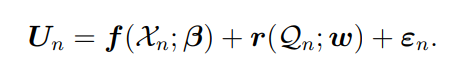

Donde:

- $U_n$ representa la utilidad del individuo $n$

- $f(\chi _n, \beta)$ representa el término impulsado por el conocimiento, que se asume interpretable. Acá $\Chi _n$ es un conjunto de características interpretables, por ejemplo, costo, tiempo, distancia, etc. $\beta$ corresponde a un vector con los parámetros a ser estimados para el buen ajuste del modelo.

- $r(Q_n, \omega)$  es el término impulsado por los datos, es una representación aprendida desde el conjunto de características $Q_n$, que pueden ser variables que se piensa que afectan a las decisiones de los individuos pero que no se sabe interpretar como, por ejemplo, el clima, la hora, etc. Este conjunto no necesariamente debe ser disjunto de $\chi _n$ pero se muestra en el paper que conviene que lo sea. Por su parte, $\omega$ corresponde a los parámetros aprendidos por la red 
neuronal.

- $\varepsilon _n$ corresponde al error, en la modelación se asume que se distribuye como una variable aleatoria [Gumbel](https://cran.r-project.org/web/packages/mlogit/vignettes/c3.rum.html) con locación $0$ y escala $1$, esto se asume así para que tenga sentido aplicar un modelo Logit Multinomial.

Con ello, la formulación final del modelo llamado 'Learning-MNL' (L-MNL) está dada por la siguiente expresión:

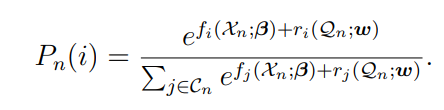


Siendo $P_n(i)$ la probabilidad de que el individuo $n$ escoga la alternativa $i$, $\mathcal{C} _n$ corresponde al conjunto de todas las alternativas disponibles para el $n$-ésimo individuo. 

A continuación, veamos la arquitectura propuesta por los investigadores para L-MNL:

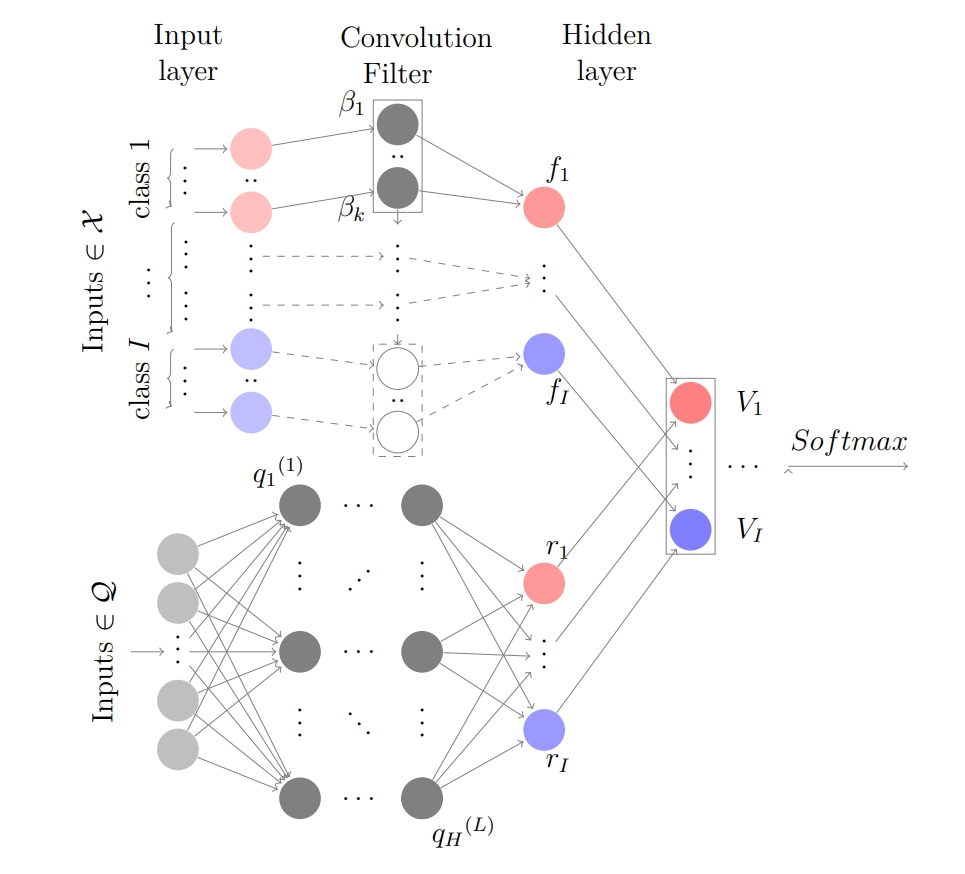

Es de suma importancia comprender la imagen anterior, dado que esta lleva en sí la idea de trasfondo del paper. Primero, notemos que la presencia de una red neuronal convolucional (CNN) cuyo input está ordenado verticalmente para cada clase. Esta CNN no es más que una manera astuta de implementar el MNL, ya que las especificaciones de su arquitectura (filtro y stride del tamaño del número de betas, una sola capa oculta y la disposición de su input) permiten que utilizando como función de activación Softmax, su output sea justamente el MNL, por lo que no se debe pensar como algo más sofisticado que eso. Por otra parte, se tiene en gris una DNN, que recibe como input el conjunto de características Q, las cuales no presentan ningún orden en particular ya que es una red densa, obteniendo de acá el término de representación $r_i$ que luego será adicionado al término $f_i$ saliente de la CNN, para que al aplicar Softmax se recupere el modelo planteado por los autores. Con ello, se verifica que la arquitectura presentada corresponde a una manera de escribir el modelo de DCM como una RNN.

Vale la pena observar que hace sentido pensar que esta astuta manera de escribir la parte lineal de la utilidad tiene relación con la implementación en código, ya que los parámetros de la red neuronal se deben ajustar en **simultáneo** para llegar (intentar llegar) al óptimo, y también notar que la interpretabilidad de esta arquitectura viene dada únicamente de la parte relacionada al MNL. En la modelación, los autores establecen que el input relativo a X tiene las características Interpretables, mientras que el input relativo a Q no, con esto y la condición de que la elasticidad se impone (o asume) nula en la salida de la DNN, se concluye que toda la interpretabilidad del modelo reside en el MNL, lo que puede ser un punto de mejora ya que hoy en día existen herramientas que permiten interpretar las decisiones tomadas por RNN. En este punto, cabe mencionar que la imposición de que $\frac{\partial r_i}{\partial t_i} = 0$, con $t_i$ la alternativa $i$, no tiene consecuencias prácticas en el sentido de la preparación del dataset o limitantes de casos en que el modelo se pueda aplicar, sus implicaciones no son aclaradas en el paper, y según lo reflexionado en torno a esto, puede tener consecuencias en la capacidad predictiva del modelo. 

Como último comentario, notar que la decisión de considerar una DNN para el término de representación, implica que para los parámetros no ajustados, todas las características influyen en las demás. Por ejemplo, en un estudio de elección entre Auto y Bus para transportarse, las características presentes en Bus afectarían la elección de Auto, lo que debe ser aprendido por la red neuronal, pero que a priori dirá que sí; esto se estudia en el paper al enfrentar el modelo a data sintética.

## Implementación
En lo siguiente, se implementa en código el modelo anteriormente estudiado, para hacer esto se utilizará la implementación del [Repositorio de los autores del paper](https://github.com/BSifringer/EnhancedDCM/tree/master), la cual se realizó con la libreria Keras. Otra implementación posible es la hecha en el siguiente [Repositorio](https://github.com/artefactory/choice-learn/tree/main), la cual es más reciente y se encuentra implementada en TensorFlow.

In [478]:
# Las siguientes librerías son necesarias para la implementación del modelo
import numpy as np
from keras.models import Model
from keras.layers import Input, Dense, Activation, Dropout, Flatten, Concatenate
from keras.layers import Conv2D, Add, Reshape

El siguiente código fue extraído del siguiente [script](https://github.com/BSifringer/EnhancedDCM/blob/master/utilities/models.py), renombrado de _enhancedMNL_extraInput_ a _learning_MNL_ para evitar confusiones. Este modelo es la implementación del acoplamiento del modelo logit multinomial (MNL) con la red neuronal densa (DNN) explicada anteriormente. Para comprender el código, se desglosará su flujo en sus grandes bloques y el detalle será relegado a la lectura misma del código, que se completó con descripciones detallistas de lo hecho. 

Dividiremos el análisis en 4 partes: Input, Red Neuronal Convolucional (CNN), Red Neuronal Densa (DNN) y Utilidad Final.

Veamos el Input:

```python
def learning_MNL(beta_num, choices_num, nExtraFeatures, networkSize, hidden_layers=1, train_betas=True,
						   minima=None, logits_activation='softmax'):
	""" L-MNL Model
		1) Main Input (X) follows the MNL architecture till Utilities
		2) Extra Input (Q) follows the DNN architecture till new feature
		3) Both terms are added to make Final Utilities
	"""
```

Se observa que recibe los siguientes parámetros:
- ``beta_num``:  Número de coeficientes beta utilizados en el modelo, son los asociados a la parte lineal, i.e, del MNL
- ``choices_num``: Número de opciones o elecciones disponibles para los individuos.
- ``nExtraFeatures``: Número de características de Q, i.e, relacionadas al término de representación.
- ``networkSize``: Tamaño de la red, es decir, el número de neuronas en cada capa densa.
- ``hidden_layers``: Número de capas ocultas en la red neuronal (por defecto es 1).
- ``train_betas``: booleano que indica si los coeficientes beta son entrenables o no.
- ``minima``: Pesos iniciales opcionales para la capa de utilidades lineales.
- ``logits_activation``: Función de activación aplicada a las utilidades finales, por defecto es softmax.

Ahora, veamos la parte de la CNN:
 ```python
 if minima is None:
		utilities = Conv2D(filters=1, kernel_size=[beta_num,1], strides=(1,1), padding='valid', name='Utilities',
			use_bias=False, trainable=train_betas)(main_input)
	else:
		utilities = Conv2D(filters=1, kernel_size=[beta_num,1], strides=(1,1), padding='valid', name='Utilities',
			use_bias = False, weights=minima, trainable=train_betas)(main_input)
 ```

Acorde a si minima es ``None`` o no, se define la CNN de una forma u otra. Minima es una estimación inicial que quien modele le puede entregar a modo de heurística al modelo. Del código lo importante es notar que el hecho de que se tenga un filtro, un kernel igual a la cantidad de betas y un stride igual a $(1,1)$, se permite implementar el modelo MNL como se comento en la parte anterior, hacerlo de esta manera hace ver la simplicidad que se tendrá para ajustar en simúltaneo los parámetros beta y los asociados a la DNN, además de una rápida implementación del modelo MNL. 

En la tercera parte tenemos la DNN:

```python
	dense = Conv2D(filters=networkSize, kernel_size=[nExtraFeatures, 1], activation='relu', padding='valid', name='Dense_NN_per_frame')(extra_input)
	dropped = Dropout(0.2, name='Regularizer')(dense)
	
	x = dropped
	for i in range(hidden_layers-1):
		x = Dense(units=networkSize, activation='relu', name="Dense{}".format(i))(x)
		x = Dropout(0.2, name='Drop{}'.format(i))(x)
	dropped = x
```

Este bloque de código corresponde a la implementación de la DNN, se observa que comienza definiendo ``dense`` con una CNN, esto para facilitar la forma en que se entrena el modelo, la forma en que se define esta CNN es tal que corresponde a una DNN de una capa, y en caso de que quien modele el problema quisiera agregar capas, se agrega en la segunda porción de ese código cada capa densa, con función de activación ReLu y DropOut del $20%$. 

Por último, tenemos la Utilidad final:

```python 
new_feature = Dense(units=choices_num, name="Output_new_feature")(dropped)
	
	new_featureR = Reshape([choices_num], name='Remove_Dim')(new_feature)
	utilitiesR = Reshape([choices_num], name='Flatten_Dim')(utilities)

	final_utilities = Add(name="New_Utility_functions")([utilitiesR, new_featureR])
    
	logits = Activation(logits_activation, name='Choice')(final_utilities)
```


Esta porción del código tiene como objetivo computar adecuadamente los $r_i$ y $f_i$ asociados a la función de utilidad, esto lo hace vectorialmente y se ve reflejado en la penúltima linea de código, donde suma tales valores, que luego serán retornados por el modelo tras la aplicación de la función _softmax_.


In [479]:
def learning_MNL(beta_num, choices_num, nExtraFeatures, networkSize, hidden_layers=1, train_betas=True,
                           minima=None, logits_activation='softmax'):
    """ 
    Modelo L-MNL mejorado:
        1) La entrada principal (X) sigue la arquitectura MNL hasta las utilidades.
        2) La entrada adicional (Q) sigue una arquitectura de Red Neuronal Profunda (DNN) hasta obtener nuevas características.
        3) Ambas contribuciones se suman para formar las utilidades finales.
    """

    # Definición de la entrada principal (X) para el modelo MNL: es un tensor con forma (beta_num, choices_num, 1)
    main_input = Input((beta_num, choices_num, 1), name='Features')

    # Definición de la entrada adicional (Q) que contiene características extra: tensor de forma (nExtraFeatures, 1, 1)
    extra_input = Input((nExtraFeatures, 1, 1), name='Extra_Input')

    # Condición para inicializar la capa Conv2D sin pesos (si minima es None) o con pesos predefinidos (si minima no es None)
    if minima is None:
        # Capa Conv2D que calcula las utilidades, utilizando filtros de tamaño (beta_num, 1) sin sesgo.
        utilities = Conv2D(filters=1, kernel_size=[beta_num, 1], strides=(1, 1), padding='valid', name='Utilities',
                           use_bias=False, trainable=train_betas)(main_input)
    else:
        # Si se proporcionan pesos mínimos, se utilizan como inicialización de la capa Conv2D.
        utilities = Conv2D(filters=1, kernel_size=[beta_num, 1], strides=(1, 1), padding='valid', name='Utilities',
                           use_bias=False, weights=minima, trainable=train_betas)(main_input)

    # Procesamiento de la entrada adicional (Q) a través de una capa Conv2D, transformándola en una representación de tamaño networkSize
    # esto genera una capa densa normal
    dense = Conv2D(filters=networkSize, kernel_size=[nExtraFeatures, 1], activation='relu', padding='valid', name='Dense_NN_per_frame')(extra_input)
    
    # Regularización con Dropout para prevenir sobreajuste, utilizando una tasa de 0.2
    dropped = Dropout(0.2, name='Regularizer')(dense)
    
    # Se crean capas ocultas adicionales si se especifica un número mayor de 1 capa oculta
    x = dropped
    for i in range(hidden_layers-1):
        # Añadimos capas densas con activación ReLU y luego Dropout para cada una de las capas ocultas
        x = Dense(units=networkSize, activation='relu', name="Dense{}".format(i))(x)
        x = Dropout(0.2, name='Drop{}'.format(i))(x)
    dropped = x

    # Se genera una nueva característica a partir de la salida de las capas ocultas
    new_feature = Dense(units=choices_num, name="Output_new_feature")(dropped)
    
    # Remodelamos la nueva característica y las utilidades para tener la misma dimensión antes de sumarlas
    new_featureR = Reshape([choices_num], name='Remove_Dim')(new_feature)
    utilitiesR = Reshape([choices_num], name='Flatten_Dim')(utilities)

    # Suma de las utilidades provenientes de ambas entradas (la principal y la adicional)
    final_utilities = Add(name="New_Utility_functions")([utilitiesR, new_featureR])

    # Aplicamos la función de activación (ej. softmax) a las utilidades finales para obtener las probabilidades de elección
    logits = Activation(logits_activation, name='Choice')(final_utilities)

    # Creamos el modelo final que recibe ambas entradas y produce las probabilidades de elección como salida
    model = Model(inputs=[main_input, extra_input], outputs=logits)
    
    # Retornamos el modelo construido
    return model


## Prueba con implementación base de L-MNL

Con el motivo de probar el modelo implementado, se ejecutará con la data sintética no correlacionada del paper, para ello se utiliza código extraído del repositorio del paper. Cabe notar la complejidad relacionada para realizar una prueba, esto se debe a como se generó la data, teniendo que ser manipulada para ser admisible por el modelo. 

In [480]:
import numpy as np
import pandas as pd
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy
from keras.metrics import CategoricalAccuracy

In [28]:
namepath = 'keras_input_generated_0_noASC_train.npy'


In [29]:
import numpy as np
from keras.models import Sequential, Model
from keras.models import load_model
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
from keras.metrics import Accuracy
from keras.callbacks import EarlyStopping


fileName = 'generated'

def keras_input(filePath, fileInputName, filePart = '', simpleArchitecture = False, write = True, lmnlArchitecture = False, trueArchitecture=False):
    """
    Prepares Input for Models. Based on Dataset, utility functions and number of alternatives

    :param filePath:        path to dataset
    :param fileInputName:   name of dataset
    :param filePart:        dataset extension (e.g. _train, _test)
    :param simpleArchitecture:  Smaller Utility Function
    :param write:           Save X and Q inputs in a .npy
    :param lmnlArchitecture:    L-MNL Utility Function (Small and no ASC)
    :param trueArchitecture:    Ground Truth Utility Specification
    :return:    train_data: X inputs Table with Choice label,
                extra_data: Q inputs vector
                train_data_name: saved name to X's .npy file
    """
    extend = ''
    if simpleArchitecture:
        extend = '_simple'
    if lmnlArchitecture:
        extend = '_noASC'
    if trueArchitecture:
        extend = '_true'

    train_data_name = filePath+ 'keras_input_' + fileInputName + extend + filePart + '.npy'

    data = np.loadtxt(filePath + fileInputName + filePart + '.dat',skiprows = 1)
    choices_num = 2


    #Define:
    x1 = data[:,0]
    x2 = data[:,1]
    x3 = data[:,2]
    x4 = data[:,3]
    x5 = data[:,4]
    choice = data[:,-1]

    choice1 = choice == 1
    choice2 = choice == 0

    ASCs = np.ones(choice.size)
    ZEROs = np.zeros(choice.size)

    """Utility Specifications: """
    train_data = np.array(
        [[ASCs, x1,  x2, x3, x4, x5, choice1]#,
      #   [ZEROs, ZEROs, x2, ZEROs, ZEROs, ZEROs, choice2]
          ])

    if simpleArchitecture:    
        train_data = np.array(
            [[ASCs, x1, x2, choice1]])

    if lmnlArchitecture:
        train_data = np.array(
            [[x1, x2,x3, choice1]#,
          #  [ZEROs, x2, choice1]
        ])

    if trueArchitecture:
        train_data = np.array(
            [[x1, x2, x3*x4, x3*x5, choice1]])

    train_data = np.swapaxes(train_data,0,2)

    if write:
        np.save(train_data_name, np.array(train_data, dtype=np.float32))

    #delete_list = range(len(data))
    #delete_list = np.delete(delete_list, [2,3,4])
    
    if simpleArchitecture or lmnlArchitecture:
        # Hybrid Simple
        extra_data = np.delete(data,[1,2,3,5],axis = 1)
        #extra_data = data[:,3:5]
    else:
        # Hybrid MNL
        extra_data = np.array([np.delete(data,range(len(data)),axis = 1)])

    if write:
        np.save(train_data_name[:-4] + '_extra.npy', extra_data)

    return train_data, extra_data, train_data_name


In [31]:
train_data, extra_data, train_data_name = keras_input('generated_data/', 'generated_0', filePart = '_test', lmnlArchitecture=True, write = True)

In [32]:
labels = train_data[:, -1, 0]

# Preparar las entradas para el modelo
train_data = train_data[:, :-1, :] 
train_data = np.expand_dims(train_data, axis=-1)  
extra_data = np.expand_dims(extra_data, axis=-1)

In [33]:
model = learning_MNL(
    beta_num=3, 
    choices_num=1,  # Clasificación binaria
    nExtraFeatures=2,  
    networkSize=200, 
    hidden_layers=1,  
    logits_activation='sigmoid'  # sigmoide coincide con softmax en el caso binario
)

In [34]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=BinaryCrossentropy(),
    metrics=[Accuracy()]
)

In [35]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    [train_data, extra_data],  # Entradas
    labels,  # Salidas
    batch_size=32,
    epochs=50,
    validation_split=0.2,
    callbacks=[early_stopping]
)

Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.0000e+00 - loss: 0.5766 - val_accuracy: 0.0000e+00 - val_loss: 0.5679
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0000e+00 - loss: 0.5579 - val_accuracy: 0.0000e+00 - val_loss: 0.5574
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.0000e+00 - loss: 0.5474 - val_accuracy: 0.0000e+00 - val_loss: 0.5478
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.0000e+00 - loss: 0.5394 - val_accuracy: 0.0000e+00 - val_loss: 0.5391
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.0000e+00 - loss: 0.5297 - val_accuracy: 0.0000e+00 - val_loss: 0.5304
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.0000e+00 - loss: 0.5225 - val_accuracy: 0.0000e+00 - val_loss: 0.5212
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0000e+00 - loss: 0.5066 - val_accuracy: 0.0000e+00 - val_loss: 0.5143
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - ac

In [491]:
# Cargar los datos de prueba
test_data = np.load('keras_input_generated_0_noASC_test.npy')  
test_extra_data = np.load('keras_input_generated_0_noASC_test_extra.npy')  

test_labels = test_data[:, -1, 0]


test_data = test_data[:, :-1, :]  
test_data = np.expand_dims(test_data, axis=-1)  
test_extra_data = np.expand_dims(test_extra_data, axis=-1)  

test_loss, test_accuracy = model.evaluate([test_data, test_extra_data], test_labels)
print(f'Test loss: {test_loss:.4f}')


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.0000e+00 - loss: 0.4293
Test loss: 0.4268


# Repositorio

En esta sección se explica las consideraciones necesarias para ejecutar pruebas con el repositorio de los autores del paper. 

En primer lugar, se debe notar que el repositorio fue creado en 2018-2019, por lo que las versiones de las librerías están fuertemente desactualizadas, pese a que el repositorio no contiene un archivo ```requirements.txt```, sí especifica que las librerías y versiones necesarias:

- Python 3.6.3
- TensorFlow 1.5.0
- Keras 2.2.4

Para visualizar, las isguientes librerías, que no se especifica las versiones usadas:

- matplotlib
- seaborn
- tqdm

Luego, recalcar que el objetivo del repositorio es esencialmente replicar los experimentos hechos por ellos, por lo que probar con otros datasets no es directo, para ello conviene más la librería choice_learn y se explica en la sección correspondiente como hacer esto. 

El repositorio se divide esencialmente en tres grandes carpetas que modularizan el código:
- ``utilities``: Contiene un script con los modelos y dos scripts para entrenarlos y realizar predicciones en test, además de un script para visualizaciones.
- ``ready_example``: Contiene todos los archivos necesarios para replicar y visualizar el experimento de SwissMetro.
- ``research_examples``: Contiene los scripts para generar la data sintética y semi-sintética.

Se explica que por motivos de uso de memoria no se publicó todos los archivos para visualizar los experimentos directamente, pero que basta con generar la data para replicar lo hecho en el paper. Para hacer esto en el caso de la data sintética, se debe observar que la carpeta ``research_examples`` contiene un archivo llamado ``generate_all.sh`` que contiene las instrucciones para generar toda la data necesaria, por lo que ejecutando desde el directorio raíz los siguientes comandos en la temrinal, se tendrá lo buscado:

```powershell
cd research_examples/generated_data/
.generate_all.sh
```

Y desde ``research_examples/`` se debe ejecutar la siguiente línea en la terminal para realizar el experimento:

```powershell
python3 generated_run.py --scan --mc --mc_hr --corr --unseen
```

En el caso de la data semi sintética es similar, basta con ejecutar los comandos:

```powershell
cd research_examples/semi_synthetic/
python3 synth_data_generator.py 
```
y luego desde ``research_examples/`` ejecutar:
```powershell
python3 semi_synthetic_run.py
```

En el caso de querer probar con otro set de datos, se debe adaptar el script ``data_manager.py`` acorde a los datos de entrada, para entender como realizar esto vale la pena observar estos scripts tanto en el caso de data sintética como SwissMetro, además, se debe crear para el caso un script ```main '_run.py'``` apropiado, la forma más fácil de hacer esto es copiando uno simple, por ejemplo, ```swissmetro_paper_run.py```, luego, cambiar el import de data_manager, las rutas de los archivos, el número de alternativas a elegir, el número de betas y el número de extra features.

# ChoiceLearn


## Ejemplo con data set SwissMetro usando la libreria ChoiceLearn
Como se mencionó inicialmente, la librería ``choice_learn`` cuenta con una implementación de diversos modelos para DCM, entre ellos cuenta con una implementación en _TensorFlow_ de L-MNL, la cuál resulta más eficiente que la implementada por los autores del paper. Esto principalmente por dos motivos, el primero es por la comparativa entre Keras y TensorFlow, siendo la primera una sublibreria de TensorFlow que ese de más alto nivel y por ello de más lenta ejecución, y la segunda es que la preparación de la data requiere menos trabajo, ya que en el caso del paper la implementación hecha no es generalizable a más datasets ni es en sí misma eficiente en su implementación. Por esto, se explicará un caso de aplicación en el dataset _SwissMetro_ que corresponde al primer caso real estudiado en el paper, el cual se encuentra disponible en el siguiente [link](https://github.com/BSifringer/EnhancedDCM/blob/master/ready_example/swissmetro_paper/swissmetro.dat)

In [397]:
import os
import sys

sys.path.append("../../")

#asegurarse de tener las librerias necesarias
# para instalarlas correr el siguiente comando en la consola: pip install -r requirements.txt o bien pip install choice-learn 

from choice_learn.datasets import load_swissmetro
from choice_learn.data import ChoiceDataset 

In [492]:
#importamos los datos de swissmetro desde el repositorio del paper
test_df = pd.read_csv("https://raw.githubusercontent.com/BSifringer/EnhancedDCM/refs/heads/master/ready_example/swissmetro_paper/swissmetro_test.dat", sep="\t")
train_df = pd.read_csv("https://raw.githubusercontent.com/BSifringer/EnhancedDCM/refs/heads/master/ready_example/swissmetro_paper/swissmetro_train.dat", sep="\t")

In [493]:
# veamos las dimensiones de los datasets y luego sus primeras 5 filas
print(test_df.shape)
print(train_df.shape)


(2145, 28)
(8574, 28)


In [427]:
test_df.head()

,GROUP,SURVEY,SP,ID,PURPOSE,FIRST,TICKET,WHO,LUGGAGE,AGE,...,TRAIN_TT,TRAIN_CO,TRAIN_HE,SM_TT,SM_CO,SM_HE,SM_SEATS,CAR_TT,CAR_CO,CHOICE
0,2,0,1,310,3,0,6,1,1,3,...,103,2600,30,57,4160,20,0,0,0,1
1,3,1,1,950,4,0,1,1,0,2,...,336,65,30,84,97,20,0,416,170,1
2,2,0,1,384,3,1,7,1,1,5,...,148,2610,120,107,3480,30,0,0,0,1
3,3,1,1,989,4,0,1,1,1,3,...,158,38,60,116,57,30,0,110,65,1
4,3,1,1,946,4,0,1,1,0,2,...,149,34,30,66,43,20,0,117,55,1


In [401]:
train_df.head()

,GROUP,SURVEY,SP,ID,PURPOSE,FIRST,TICKET,WHO,LUGGAGE,AGE,...,TRAIN_TT,TRAIN_CO,TRAIN_HE,SM_TT,SM_CO,SM_HE,SM_SEATS,CAR_TT,CAR_CO,CHOICE
0,2,0,1,401,5,0,1,3,1,3,...,97,42,30,46,56,20,1,60,65,1
1,2,0,1,15,1,0,1,2,1,3,...,97,26,30,48,40,20,1,0,0,1
2,2,0,1,425,7,0,1,1,1,1,...,170,59,30,115,66,10,1,144,85,1
3,2,0,1,433,7,0,7,1,1,1,...,130,2220,30,79,2960,20,1,0,0,1
4,3,1,1,1187,4,1,6,1,0,3,...,179,17,120,168,23,30,0,130,44,1


In [428]:
# el siguiente código es para filtrar el dataframe de la manera que se hace en el paper, es decir,
# se eliminan las filas donde algún individuo no cuente con alguna de las alternativas de transporte
# lo que asegura que cada persona tiene a su disposición las 3 alternativas de transporte


test_df = test_df.loc[test_df.CAR_AV == 1]
test_df = test_df.loc[test_df.SM_AV == 1]
test_df = test_df.loc[test_df.TRAIN_AV == 1]

train_df = train_df.loc[train_df.CAR_AV == 1]
train_df = train_df.loc[train_df.SM_AV == 1]
train_df = train_df.loc[train_df.TRAIN_AV == 1]

In [429]:
# Se normaliza los valores por un factor de 100 según se estipula en el paper, esto es para evitar problemas de convergencia de la DNN
# esta práctica es usual en ML, ya que los valores muy grandes pueden afectar el entrenamiento de la red. Usualmente se elige escalar
# los valores por max-min, o Q3-Q1, por la desviación estándar u otro método, pero en este caso se elige escalarlos por 100

# Normalizing values by 100
train_df[["TRAIN_TT", "SM_TT", "CAR_TT"]] = (
    train_df[["TRAIN_TT", "SM_TT", "CAR_TT"]] / 100.0
)

train_df[["TRAIN_HE", "SM_HE"]] = (
    train_df[["TRAIN_HE", "SM_HE"]] / 100.0
)

train_df["train_free_ticket"] = train_df.apply(
    lambda row: (row["GA"] == 1).astype(int), axis=1
)
train_df["sm_free_ticket"] = train_df.apply(
    lambda row: (row["GA"] == 1).astype(int), axis=1
)

train_df["TRAIN_travel_cost"] = train_df.apply(
    lambda row: (row["TRAIN_CO"] * (1 - row["train_free_ticket"])) / 100, axis=1
)
train_df["SM_travel_cost"] = train_df.apply(
    lambda row: (row["SM_CO"] * (1 - row["sm_free_ticket"])) / 100, axis=1
)
train_df["CAR_travel_cost"] = train_df.apply(lambda row: row["CAR_CO"] / 100, axis=1)


# Normalizing values by 100
test_df[["TRAIN_TT", "SM_TT", "CAR_TT"]] = (
    test_df[["TRAIN_TT", "SM_TT", "CAR_TT"]] / 100.0
)

test_df[["TRAIN_HE", "SM_HE"]] = (
    test_df[["TRAIN_HE", "SM_HE"]] / 100.0
)

test_df["train_free_ticket"] = test_df.apply(
    lambda row: (row["GA"] == 1).astype(int), axis=1
)
test_df["sm_free_ticket"] = test_df.apply(
    lambda row: (row["GA"] == 1).astype(int), axis=1
)

test_df["TRAIN_travel_cost"] = test_df.apply(
    lambda row: (row["TRAIN_CO"] * (1 - row["train_free_ticket"])) / 100, axis=1
)
test_df["SM_travel_cost"] = test_df.apply(
    lambda row: (row["SM_CO"] * (1 - row["sm_free_ticket"])) / 100, axis=1
)
test_df["CAR_travel_cost"] = test_df.apply(lambda row: row["CAR_CO"] / 100, axis=1)


In [430]:
# esta parte es más bien técnica, se convierten las columnas a float32 para evitar problemas de memoria
# en el entrenamiento de la red, esto es porque float32 es un tipo de dato que ocupa la mitad de memoria que float64
# y en este caso no se requiere de tanta precisión en los valores

train_df.SM_SEATS = train_df.SM_SEATS.astype("float32")
test_df.SM_SEATS = test_df.SM_SEATS.astype("float32")


# Se resta 1 a la columna CHOICE para que los valores vayan de 0 a 2 en lugar de 1 a 3, que es lo requerido para el modelo

train_df.CHOICE = train_df.CHOICE - 1
test_df.CHOICE = test_df.CHOICE - 1

La siguiente parte es clave, para ello véamosla con un poco más de detalle.

Creación de conjuntos de datos para el modelo:

```
dataset = ChoiceDataset.from_single_wide_df(...)

train_dataset = ChoiceDataset.from_single_wide_df(...)

test_dataset = ChoiceDataset.from_single_wide_df(...) 
```

- ``ChoiceDataset.from_single_wide_df``: Convierte los DataFrames en objetos ChoiceDataset necesarios para el modelo. 

Sus parámetros son:

- ``choices_column="CHOICE"``: Indica la columna que contiene la elección realizada.

- ``items_id=["TRAIN", "SM", "CAR"]``: Especifica las opciones de transporte disponibles (CAR, TRAIN y SM).
- ``shared_features_columns``: Lista de columnas con características compartidas entre todas las opciones.
- ``items_features_suffixes``: Sufijos que identifican las características específicas de cada opción (tiempo de viaje, costo de viaje, frecuencia de servicio).
- ``choice_format="items_index"``: Especifica el formato en que se almacenan las elecciones.

Como se observa en el código, esto se realizará esto tanto para train como para test.

In [432]:
train_dataset = ChoiceDataset.from_single_wide_df(df=train_df, choices_column="CHOICE", items_id=["TRAIN", "SM", "CAR"],
shared_features_columns=["GA", "AGE", "LUGGAGE", "SM_SEATS", 'PURPOSE', 'FIRST', 'TICKET', 'WHO', 'MALE', 'INCOME', 'ORIGIN', 'DEST'],
items_features_suffixes=["TT", "travel_cost", "HE"], choice_format="items_index")

test_dataset = ChoiceDataset.from_single_wide_df(df=test_df, choices_column="CHOICE", items_id=["TRAIN", "SM", "CAR"],
shared_features_columns=["GA", "AGE", "LUGGAGE", "SM_SEATS", 'PURPOSE', 'FIRST', 'TICKET', 'WHO', 'MALE', 'INCOME', 'ORIGIN', 'DEST'],
items_features_suffixes=["TT", "travel_cost", "HE"], choice_format="items_index")

In [477]:
# veamos ahora las dimensiones de los datasets resultantes
print(len(train_dataset), len(test_dataset))

7234 1802


In [437]:
# una vez preprocesada la data, se puede proceder a entrenar el modelo Learning MNL de la manera descrita en el paper,
# esto es, con 200 épocas, optimizador Adam, learning rate de 0.005, y una red neuronal con una capa oculta de 200 neuronas, sin fijar la semilla
from choice_learn.models.learning_mnl import LearningMNL

swiss_model = LearningMNL(optimizer="Adam", lr=0.005,
nn_features=['PURPOSE', 'FIRST', 'TICKET', 'WHO', 'MALE', 'INCOME', 'ORIGIN', 'DEST'], nn_layers_widths=[200], epochs=200, batch_size=32) 

#En el paper se menciona qué coeficientes son compartidos y específicos, por ello se aclara en el modelo

# se puede especificar los coeficientes compartidos y específicos de la siguiente manera
swiss_model.add_shared_coefficient(feature_name="TT", items_indexes=[0, 1, 2])  # coeficiente compartido
swiss_model.add_shared_coefficient(feature_name="travel_cost", items_indexes=[0, 1, 2])
swiss_model.add_shared_coefficient(feature_name="HE", items_indexes=[0, 1])
swiss_model.add_shared_coefficient(feature_name="GA", items_indexes=[0, 1])
swiss_model.add_shared_coefficient(feature_name="AGE", items_indexes=[0]) # coeficiente específico
swiss_model.add_shared_coefficient(feature_name="LUGGAGE", items_indexes=[2])
swiss_model.add_shared_coefficient(feature_name="SM_SEATS", items_indexes=[1])
swiss_model.add_coefficients(feature_name="intercept", items_indexes=[1, 2])

Epoch 199 Train Loss 0.6578: 100%|██████████| 200/200 [20:47<00:00,  6.24s/it]


In [ ]:
# se entrena el modelo con el dataset de entrenamiento y se valida con el dataset de prueba,
# el siguiente código demora al rededor de 20 minutos en correr
hist = swiss_model.fit(train_dataset, val_dataset=test_dataset, verbose=1)

In [438]:
# esta celda de código es prescindible, se presenta para mostrar como se puede reentrenar el modelo, en este caso con un learning rate menor
# lo que permite ajustar con mayor presición los parámetros a entrenar
swiss_model.assign_lr(0.001)
hist2 = swiss_model.fit(train_dataset, val_dataset=test_dataset, verbose=1)

Epoch 199 Train Loss 0.6590: 100%|██████████| 200/200 [19:57<00:00,  5.99s/it]


In [444]:
# se utiliza un batch_size de 32 para evitar problemas de memoria, y se retorna el error medio de todas las muerstras
swiss_model.evaluate(train_dataset, batch_size=32)  

<tf.Tensor: shape=(), dtype=float32, numpy=0.6482584476470947>

In [445]:
swiss_model.evaluate(test_dataset, batch_size=32) 

<tf.Tensor: shape=(), dtype=float32, numpy=0.6754730939865112>

In [441]:
# Se muestra los parámetros estimados por el modelo luego del entrenamiento
swiss_model.trainable_weights[:8]

[<tf.Variable 'beta_TT:0' shape=(1, 1) dtype=float32, numpy=array([[-1.5320207]], dtype=float32)>,
 <tf.Variable 'beta_travel_cost:0' shape=(1, 1) dtype=float32, numpy=array([[-1.4470152]], dtype=float32)>,
 <tf.Variable 'beta_HE:0' shape=(1, 1) dtype=float32, numpy=array([[-0.82292074]], dtype=float32)>,
 <tf.Variable 'beta_GA:0' shape=(1, 1) dtype=float32, numpy=array([[0.8814941]], dtype=float32)>,
 <tf.Variable 'beta_AGE:0' shape=(1, 1) dtype=float32, numpy=array([[0.38130516]], dtype=float32)>,
 <tf.Variable 'beta_LUGGAGE:0' shape=(1, 1) dtype=float32, numpy=array([[0.10375606]], dtype=float32)>,
 <tf.Variable 'beta_SM_SEATS:0' shape=(1, 1) dtype=float32, numpy=array([[-0.10263199]], dtype=float32)>,
 <tf.Variable 'beta_intercept:0' shape=(1, 2) dtype=float32, numpy=array([[-0.05460942,  0.08797138]], dtype=float32)>]

In [ ]:
# veamos el accuracy del modelo en el conjunto de prueba
probas = swiss_model.predict_probas(test_dataset, batch_size=32)

#tenemos las probabilidades de que cada alternativa sea escogida, por lo que diremos que se escoge la alternativa con mayor probabilidad

probas = probas.numpy()
choices = probas.argmax(axis=1)
test_labels = test_dataset.choices

# se calcula el accuracy del modelo
accuracy = (choices == test_labels).mean()
print(f"accuracy: {accuracy}")
# se calcula la precision
precision = ((choices == 1) & (test_labels == 1)).sum() / (choices == 1).sum()
print(f"precision: {precision}")

accuracy: 0.6864594894561599
precision: 0.713784021071115
